## Standardized test cases

For benchmarking, we need a standardized set of case studies, ranging form simple to very large. This helps us to test and track the performance of improvements of bw_timex with the same set of test cases.


### 0) set up variables & functions

In [1]:
import numpy as np
import bw2data as bd

from bw_temporalis import TemporalDistribution
from datetime import datetime

from cProfile import Profile
from pstats import SortKey, Stats

import time
from bw_timex import TimexLCA


In [2]:
# Define the old and new project names
old_project_name = 'Reforrestation_Aforrestation'
new_project_name = 'timex_benchmarking'

# Restore the old project
if new_project_name not in bd.projects:
    import bw2io as bi
    import shutil
    bi.backup.restore_project_directory(fp= '/Users/ajakobs/Documents/Solene_Reforrestation_Aforrestation/brightway2-project-Reforrestation_Aforrestation-backup02-June-2025-05-23PM.tar.gz',
                                    overwrite_existing=True)


    # Set the current project to the old project
    bd.projects.set_current(old_project_name)

    # Get the project directory
    old_project_dir = bd.projects.dir

    # Create a new project
    bd.projects.set_current(new_project_name)

    # Get the new project directory
    new_project_dir = bd.projects.dir

    # Copy the old project directory to the new project directory
    shutil.copytree(old_project_dir, new_project_dir, dirs_exist_ok=True)

    print(f"Project loaded and copied to {new_project_name}.")
else:
    bd.projects.set_current(new_project_name)


In [3]:
list(bd.databases)

['ecoinvent-3.11-biosphere',
 'ecoinvent-3.11-cutoff',
 'ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30',
 'ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30',
 'ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30',
 'ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30',
 'test_1tiers_2processes']

In [4]:
# Remove all test systems from the project
def clear_test_systems():
    to_delete = []
    for db in bd.databases:  # deleting all test_systems
        if "test" in db:
            to_delete.append(db)
    print(to_delete)

    for db in to_delete:
        del bd.databases[db]

    print(bd.databases)

clear_test_systems()

['test_1tiers_2processes']
Databases dictionary with 6 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30


In [5]:
base_background_db = bd.Database("ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30")

In [6]:
list_random_acts = []
for i in range(0, 100):
    act = base_background_db.random()
    list_random_acts.append((act["code"]))

In [7]:
fixed_random_acts = list_random_acts

In [8]:
def create_standardized_test_system(
    db_name,
    number_tiers,
    number_processes_per_tier,
    td_timesteps,
    td_dtype,
    fixed_random_acts,
    number_background_exchanges_per_process,
    base_background_db_name,
    loop=False,
):
    """
    Create a foreground database with a standardized structure for testing purposes. It contains number_tiers supply chain levels, with each containing
    number_processes_per_tier processes. Each process consumes from all processes in the tier below. At the last tier, each process consumes a certain numebr of background process
    Each process has a temporal distribution with td_timesteps steps, e.g. 3, in td_dtype resolution, e.g. years, starting at a unit of time later than the consuming process
    The last tier consumes a process from the background system in 2020, selecting a process from a predefined list of random processes, with the same temporal distribution as above.
    If loop = True, a loop is included: the last process in last tier consumes from the last process in first tier, no TDs at this node.
    No additional TDs at biosphere flows.

    Parameters:
    db_name: str, name of the database
    number_tiers: int, number of tiers in the supply chain
    number_processes_per_tier: int, number of processes per tier
    td_timesteps: int, number of timesteps in the temporal distribution
    td_dtype: str, dtype of the temporal distribution, e.g. "timedelta64[Y]" or "timedelta64[M]"
    fixed_random_acts: a list of 100 background activities codes that has been pre-generated
    number_background_exchanges_per_process: int, number of background exchanges per process in the last tier
    base_background_db_name: str, name of the background database to use for the last tier processes, e.g. "ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30"
    loop: bool, whether to include a loop in the foreground system

    returns: None


    """

    # create a new database
    if db_name in bd.databases:
        del bd.databases[db_name]
        print(f"Database {db_name} already exists, overwriting.")
    foreground = bd.Database(db_name)
    foreground.register()

    background_db = bd.Database(
        base_background_db_name
    )  # background database for 2020 in timex project

    # save FU node
    FU_node = foreground.new_node(code="FU", name="functional unit", unit="unit")
    FU_node.save()
    FU_node.new_edge(input=FU_node, amount=1, unit="unit", type="production").save()

    # create nodes
    for tier in range(1, number_tiers + 1):
        for process in range(1, number_processes_per_tier + 1):
            process_name = f"tier{tier}_act{process}"
            process_code = f"t{tier}_a{process}"
            process_node = foreground.new_node(
                code=process_code, name=process_name, unit="unit"
            )
            process_node.save()
            process_node.new_edge(
                input=process_node, amount=1, unit="unit", type="production"
            ).save()

    # relink nodes
    for tier in range(1, number_tiers + 1):
        for process in range(1, number_processes_per_tier + 1):
            process_name = f"tier{tier}_act{process}"
            process_code = f"t{tier}_a{process}"
            process_node = foreground.get(process_code)
            if tier == 1:  # tier 1 = FU
                consuming_node = FU_node
                new_edge = consuming_node.new_edge(
                    input=process_node, amount=1, unit="unit", type="technosphere"
                )
                new_edge.save()
            else:  # lower tiers: all nodes at the tier above consume from all nodes at the tier below, with a temporal distribution specified by the inputs
                for process in range(1, number_processes_per_tier + 1):
                    consuming_node = foreground.get(f"t{tier-1}_a{process}")
                    new_edge = consuming_node.new_edge(
                        input=process_node, amount=1, unit="unit", type="technosphere"
                    )
                    temporal_distribution = TemporalDistribution(
                        date=np.array(np.arange(1, td_timesteps + 1), dtype=td_dtype),
                        amount=np.full(td_timesteps, 1 / td_timesteps),
                    )  # linear distribution between 1 and td_timesteps in years
                    new_edge["temporal_distribution"] = temporal_distribution
                    new_edge.save()

    # add background process to nodes on last tier
    count_background_act = 0  # counting upward in list of random acts
    total_background_count = 0
    for process in range(1, number_processes_per_tier + 1):
        last_foreground_node = foreground.get(f"t{number_tiers}_a{process}")

        for _ in range(1, number_background_exchanges_per_process + 1):
            background_process = background_db.get(
                code=fixed_random_acts[count_background_act]
            )
            count_background_act += 1

            new_edge = last_foreground_node.new_edge(
                input=background_process, amount=4, type="technosphere"
            )
            temporal_distribution = TemporalDistribution(
                date=np.array(np.arange(1, td_timesteps + 1), dtype=td_dtype),
                amount=np.full(td_timesteps, 1 / td_timesteps),
            )  # linear distribution between 1 and td_timesteps in years
            new_edge["temporal_distribution"] = temporal_distribution
            new_edge.save()

            if (
                count_background_act == 99
            ):  # if all 100 background processes have been used, start again
                total_background_count += count_background_act
                count_background_act = 0

    if loop:
        # add loop to foreground: last process in last tier consumes from last process in first tier, no TDs
        loop_consumer = foreground.get(f"t{number_tiers}_a{number_processes_per_tier}")
        loop_producer = foreground.get(f"t{1}_a{number_processes_per_tier}")
        new_edge = loop_consumer.new_edge(
            input=loop_producer, amount=0.3, type="technosphere"
        )
        new_edge.save()

    count_exc = 0
    for act in foreground:
        for exc in act.technosphere():
            count_exc += 1

    total_background_count += (
        count_background_act  # number of background processes used in total
    )

    print(
        f"Database {db_name} created with {len(foreground)} processes and {count_exc} exchanges. There are {total_background_count} different background processes used."
    )
    return len(foreground), count_exc, total_background_count

### 1) small system

In [9]:
def _database_dates(db_name):
    database_dates = {
    "ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30": datetime.strptime("2020", "%Y"),
    "ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30": datetime.strptime("2030", "%Y"),
    "ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30": datetime.strptime("2040", "%Y"),
    "ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30": datetime.strptime("2050", "%Y"),
    db_name: "dynamic",
    }
    return database_dates

In [10]:
# set method
method = ('ecoinvent-3.11', 'IPCC 2021 (incl. biogenic CO2)', 'climate change: total (incl. biogenic CO2)', 'global warming potential (GWP100)')

In [11]:
n_processes = np.array([1,2,3,5,10, 20, 30])
n_tiers = np.array([1,2])
time_steps = 3

time_initialize = []
time_build_timeline = []
time_lci = []
time_lcia = []
time_total = []

# Create foreground databases with different numbers of processes and tiers
test_db_names = []
n_foreground = []
n_exchanges = []
n_background = []

for n_tier in n_tiers[:]:
    for n_process in n_processes[:]:
        db_name = f"test_{n_tier}tiers_{n_process}processes"
        database_dates = _database_dates(db_name)
        test_db_names.append(db_name)
        print(f"Processing database {db_name} with {n_tier} tiers and {n_process} processes per tier...")
        # Check if the database already exists
        if db_name not in bd.databases:
            # Create the standardized test system
            print(f"Creating database {db_name}...")
            db_name = f"test_{n_tier}tiers_{n_process}processes"
            n_fg, n_exch, n_bg = create_standardized_test_system(db_name=db_name,
                                            number_tiers=n_tier,
                                            number_processes_per_tier=n_process,
                                            td_timesteps=time_steps,
                                            td_dtype="timedelta64[Y]",
                                            fixed_random_acts=fixed_random_acts,
                                            number_background_exchanges_per_process=2,
                                            base_background_db_name="ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30",
                                            loop=False)
            n_foreground.append(n_fg)
            n_exchanges.append(n_exch)
            n_background.append(n_bg)
        
        # Process each database
        print(f"benchmarking database {db_name}...")
        # set funcitonal unit
        FU_node = bd.Database(db_name).get("FU")
        #initialize the TimexLCA object
        t0 = time.time()
        tlca = TimexLCA(demand={FU_node: 1},
        method=method,
        database_dates=database_dates,
        )
        t1 = time.time()
        time_initialize.append(t1 - t0)
        # build the timeline
        t2 = time.time()
        tlca.build_timeline()
        t3 = time.time()
        time_build_timeline.append(t3 - t2)
        # run the LCI
        t4 = time.time()
        tlca.lci()
        t5 = time.time()
        time_lci.append(t5 - t4)
        # run the LCIA
        t6 = time.time()
        tlca.static_lcia()
        t7 = time.time()
        time_lcia.append(t7 - t6)
        time_total.append(t7 - t0)
        print(f"{time.ctime()}: Database {db_name} processed in {t7 - t0:.2f} seconds.")
        print("deleting test db from project...")
        del bd.databases[db_name]

Processing database test_1tiers_1processes with 1 tiers and 1 processes per tier...
Creating database test_1tiers_1processes...
Database test_1tiers_1processes created with 2 processes and 3 exchanges. There are 2 different background processes used.
benchmarking database test_1tiers_1processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 20:51:43.079 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 2


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 20:51:57 2025: Database test_1tiers_1processes processed in 19.12 seconds.
deleting test db from project...
Processing database test_1tiers_2processes with 1 tiers and 2 processes per tier...
Creating database test_1tiers_2processes...
Database test_1tiers_2processes created with 3 processes and 6 exchanges. There are 4 different background processes used.
benchmarking database test_1tiers_2processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 20:52:02.988 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 5


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 20:52:23 2025: Database test_1tiers_2processes processed in 25.75 seconds.
deleting test db from project...
Processing database test_1tiers_3processes with 1 tiers and 3 processes per tier...
Creating database test_1tiers_3processes...
Database test_1tiers_3processes created with 4 processes and 9 exchanges. There are 6 different background processes used.
benchmarking database test_1tiers_3processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 20:52:28.928 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 8


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 20:52:52 2025: Database test_1tiers_3processes processed in 29.31 seconds.
deleting test db from project...
Processing database test_1tiers_5processes with 1 tiers and 5 processes per tier...
Creating database test_1tiers_5processes...
Database test_1tiers_5processes created with 6 processes and 15 exchanges. There are 10 different background processes used.
benchmarking database test_1tiers_5processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 20:52:58.402 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 14


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 20:53:31 2025: Database test_1tiers_5processes processed in 38.38 seconds.
deleting test db from project...
Processing database test_1tiers_10processes with 1 tiers and 10 processes per tier...
Creating database test_1tiers_10processes...
Database test_1tiers_10processes created with 11 processes and 30 exchanges. There are 20 different background processes used.
benchmarking database test_1tiers_10processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 20:53:37.129 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 28


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 20:54:35 2025: Database test_1tiers_10processes processed in 63.54 seconds.
deleting test db from project...
Processing database test_1tiers_20processes with 1 tiers and 20 processes per tier...
Creating database test_1tiers_20processes...
Database test_1tiers_20processes created with 21 processes and 60 exchanges. There are 40 different background processes used.
benchmarking database test_1tiers_20processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 20:54:41.443 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 41


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 20:56:12 2025: Database test_1tiers_20processes processed in 96.46 seconds.
deleting test db from project...
Processing database test_1tiers_30processes with 1 tiers and 30 processes per tier...
Creating database test_1tiers_30processes...
Database test_1tiers_30processes created with 31 processes and 90 exchanges. There are 60 different background processes used.
benchmarking database test_1tiers_30processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 20:56:18.665 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 61


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 20:58:26 2025: Database test_1tiers_30processes processed in 133.12 seconds.
deleting test db from project...
Processing database test_2tiers_1processes with 2 tiers and 1 processes per tier...
Creating database test_2tiers_1processes...
Database test_2tiers_1processes created with 3 processes and 4 exchanges. There are 2 different background processes used.
benchmarking database test_2tiers_1processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 20:58:31.874 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 3


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 20:58:49 2025: Database test_2tiers_1processes processed in 23.24 seconds.
deleting test db from project...
Processing database test_2tiers_2processes with 2 tiers and 2 processes per tier...
Creating database test_2tiers_2processes...
Database test_2tiers_2processes created with 5 processes and 10 exchanges. There are 4 different background processes used.
benchmarking database test_2tiers_2processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 20:58:55.326 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 12


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 20:59:20 2025: Database test_2tiers_2processes processed in 30.77 seconds.
deleting test db from project...
Processing database test_2tiers_3processes with 2 tiers and 3 processes per tier...
Creating database test_2tiers_3processes...
Database test_2tiers_3processes created with 7 processes and 18 exchanges. There are 6 different background processes used.
benchmarking database test_2tiers_3processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 20:59:26.072 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 27


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 20:59:59 2025: Database test_2tiers_3processes processed in 38.62 seconds.
deleting test db from project...
Processing database test_2tiers_5processes with 2 tiers and 5 processes per tier...
Creating database test_2tiers_5processes...
Database test_2tiers_5processes created with 11 processes and 40 exchanges. There are 10 different background processes used.
benchmarking database test_2tiers_5processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 21:00:04.984 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 75


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 21:00:57 2025: Database test_2tiers_5processes processed in 58.21 seconds.
deleting test db from project...
Processing database test_2tiers_10processes with 2 tiers and 10 processes per tier...
Creating database test_2tiers_10processes...
Database test_2tiers_10processes created with 21 processes and 130 exchanges. There are 20 different background processes used.
benchmarking database test_2tiers_10processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 21:01:03.758 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 290


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 21:02:50 2025: Database test_2tiers_10processes processed in 112.75 seconds.
deleting test db from project...
Processing database test_2tiers_20processes with 2 tiers and 20 processes per tier...
Creating database test_2tiers_20processes...
Database test_2tiers_20processes created with 41 processes and 460 exchanges. There are 40 different background processes used.
benchmarking database test_2tiers_20processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 21:02:57.866 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 280


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 21:05:13 2025: Database test_2tiers_20processes processed in 141.28 seconds.
deleting test db from project...
Processing database test_2tiers_30processes with 2 tiers and 30 processes per tier...
Creating database test_2tiers_30processes...
Database test_2tiers_30processes created with 61 processes and 990 exchanges. There are 60 different background processes used.
benchmarking database test_2tiers_30processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 21:05:21.571 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 510


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Tue Jun 10 21:08:42 2025: Database test_2tiers_30processes processed in 206.43 seconds.
deleting test db from project...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


In [12]:
for i,tier in enumerate(n_tiers[:2]):
    for j,process in enumerate(n_processes[:3]):
        db_name = f"test_{tier}tiers_{process}processes"
        print(f"Database {db_name} processed in {time_total[i*j+j]:.2f} seconds.")
        print(f"Time to initialize: {time_initialize[i*j+j]:.2f} seconds.")
        print(f"Time to build timeline: {time_build_timeline[i*j+j]:.2f} seconds.")
        print(f"Time to run LCI: {time_lci[i*j+j]:.2f} seconds.")
        print(f"Time to run LCIA: {time_lcia[i*j+j]:.2f} seconds.")

Database test_1tiers_1processes processed in 19.12 seconds.
Time to initialize: 4.44 seconds.
Time to build timeline: 8.10 seconds.
Time to run LCI: 6.58 seconds.
Time to run LCIA: 0.00 seconds.
Database test_1tiers_2processes processed in 25.75 seconds.
Time to initialize: 5.17 seconds.
Time to build timeline: 13.38 seconds.
Time to run LCI: 7.19 seconds.
Time to run LCIA: 0.00 seconds.
Database test_1tiers_3processes processed in 29.31 seconds.
Time to initialize: 5.27 seconds.
Time to build timeline: 16.22 seconds.
Time to run LCI: 7.81 seconds.
Time to run LCIA: 0.00 seconds.
Database test_2tiers_1processes processed in 19.12 seconds.
Time to initialize: 4.44 seconds.
Time to build timeline: 8.10 seconds.
Time to run LCI: 6.58 seconds.
Time to run LCIA: 0.00 seconds.
Database test_2tiers_2processes processed in 29.31 seconds.
Time to initialize: 5.27 seconds.
Time to build timeline: 16.22 seconds.
Time to run LCI: 7.81 seconds.
Time to run LCIA: 0.00 seconds.
Database test_2tiers_3

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

In [14]:
time_lcia

[0.001165151596069336,
 0.0010938644409179688,
 0.0011887550354003906,
 0.001157999038696289,
 0.0012142658233642578,
 0.0012891292572021484,
 0.0016608238220214844,
 0.0012180805206298828,
 0.0012769699096679688,
 0.0013611316680908203,
 0.0013959407806396484,
 0.0016298294067382812,
 0.0016782283782958984,
 0.0019807815551757812]

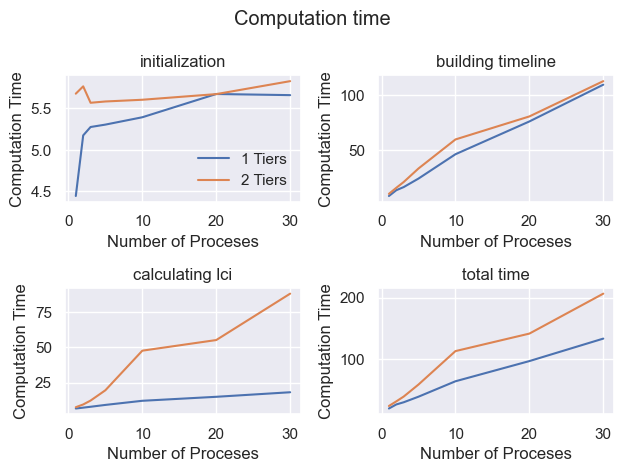

In [20]:
timing_cat_names = ['initialization','building timeline', 'calculating lci', 'total time']
timing_cats = [time_initialize,time_build_timeline, time_lci, time_total]
fig = plt.figure()

for i,(cat_name, timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    timing_cat = np.asarray(timing_cat).reshape((len(n_tiers[:]),len(n_processes[:])))
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel('Number of Proceses')
    ax.set_ylabel('Computation Time')
    ax.set_title(cat_name)
    for j,n_tier in enumerate(n_tiers[:2]):
        ax.plot(n_processes[:], timing_cat[j,:], label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig.suptitle('Computation time')
plt.tight_layout()




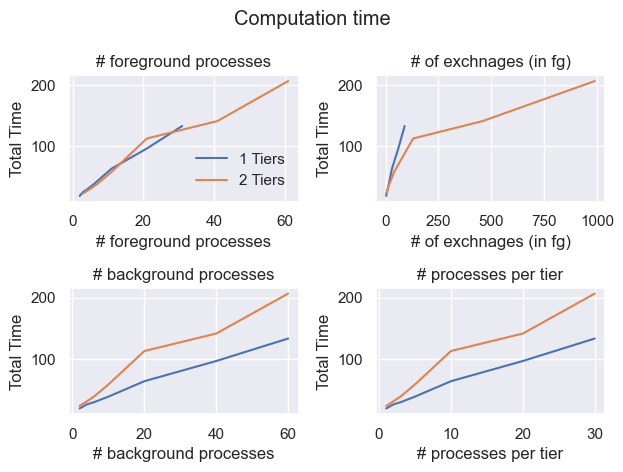

In [21]:
timing_cat_names = ['# foreground processes','# of exchnages (in fg)', '# background processes', '# processes per tier']


n_fg = np.asarray(n_foreground).reshape((len(n_tiers),len(n_processes)))
n_exch = np.asarray(n_exchanges).reshape((len(n_tiers),len(n_processes)))
n_bg = np.asarray(n_background).reshape((len(n_tiers),len(n_processes)))
N_processes = np.tile(n_processes, (len(n_tiers), 1))

timing_cats = [n_fg, n_exch, n_bg, N_processes]
ttime = np.asarray(time_total).reshape((len(n_tiers),len(n_processes)))

fig = plt.figure()



for i,(cat_name,timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel(cat_name)
    ax.set_ylabel('Total Time')
    ax.set_title(cat_name)
    for j,n_tier in enumerate(n_tiers[:2]):
        ax.plot(timing_cat[j,:], ttime[j,:], label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig.suptitle('Computation time')
plt.tight_layout()




In [33]:
time_initialize

[5.36871600151062,
 5.348928928375244,
 5.551616907119751,
 5.21621298789978,
 5.524483919143677,
 5.493585824966431]

In [35]:
time_lci

[7.035416126251221,
 7.709656000137329,
 8.41408395767212,
 8.24273681640625,
 10.077550888061523,
 12.610236167907715]

In [36]:
time_total

[21.141052961349487,
 26.238516092300415,
 31.152748107910156,
 24.018660306930542,
 30.896164894104004,
 39.10817003250122]

In [23]:
biosphere_db = bd.Database("ecoinvent-3.11-biosphere")


In [38]:
for i,m in enumerate(bd.methods):
    print(f"{i}: {m}")

0: ('ecoinvent-3.11', 'CML v4.8 2016 no LT', 'acidification no LT', 'acidification (incl. fate, average Europe total, A&B) no LT')
1: ('ecoinvent-3.11', 'CML v4.8 2016 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
2: ('ecoinvent-3.11', 'CML v4.8 2016 no LT', 'ecotoxicity: freshwater no LT', 'freshwater aquatic ecotoxicity (FAETP inf) no LT')
3: ('ecoinvent-3.11', 'CML v4.8 2016 no LT', 'ecotoxicity: marine no LT', 'marine aquatic ecotoxicity (MAETP inf) no LT')
4: ('ecoinvent-3.11', 'CML v4.8 2016 no LT', 'ecotoxicity: terrestrial no LT', 'terrestrial ecotoxicity (TETP inf) no LT')
5: ('ecoinvent-3.11', 'CML v4.8 2016 no LT', 'energy resources: non-renewable no LT', 'abiotic depletion potential (ADP): fossil fuels no LT')
6: ('ecoinvent-3.11', 'CML v4.8 2016 no LT', 'eutrophication no LT', 'eutrophication (fate not incl.) no LT')
7: ('ecoinvent-3.11', 'CML v4.8 2016 no LT', 'human toxicity no LT', 'human toxicity (HTP inf) no LT')
8: ('ecoinvent-3.11', 'CML

In [42]:
%%time
tlca = TimexLCA(
    demand={FU_node: 1},
    method=method,
    database_dates=database_dates,
    )
tlca.build_timeline()
tlca.lci()
tlca.static_lcia()

/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-10 13:54:13.407 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 12


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


CPU times: user 1min 16s, sys: 5.58 s, total: 1min 22s
Wall time: 28.7 s


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


### 2) medium system

In [18]:
# needed to avoid multiple results error https://github.com/brightway-lca/bw_timex/issues/101
to_delete = []
for db in bd.databases: #deleting all test_systems
    if "test" in db:
        to_delete.append(db)
print(to_delete)

for db in to_delete:
    del bd.databases[db] 

print(bd.databases)

['test_small']
Databases dictionary with 7 object(s):
	biosphere
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ei310_IMAGE_SSP2_RCP19_2020_electricity
	ei310_IMAGE_SSP2_RCP19_2030_electricity
	ei310_IMAGE_SSP2_RCP19_2040_electricity
	foreground


In [19]:
db_name = "test_medium"
create_standardized_test_system(db_name = db_name, number_tiers = 4, number_processes_per_tier=4,
                                td_timesteps= 2, td_dtype = "timedelta64[Y]", fixed_random_acts= fixed_random_acts, number_background_exchanges_per_process = 4,
                                loop = False)

Database test_medium created with 17 processes and 68 exchanges. There are 16 different background processes used.


In [ ]:
# check db entries:
# foreground = bd.Database(db_name)
# for act in foreground:
#     print(act)
#     for exc in act.exchanges():
#         td = exc.get("temporal_distribution", None)
#         print("--", exc["type"],"|", exc,"|", td)  
#     print ("\n")

'tier2_act4' (unit, GLO, None)
-- production | Exchange: 1 unit 'tier2_act4' (unit, GLO, None) to 'tier2_act4' (unit, GLO, None)> | None
-- technosphere | Exchange: 1 unit 'tier3_act1' (unit, GLO, None) to 'tier2_act4' (unit, GLO, None)> | TemporalDistribution instance with 2 values and total: 1
-- technosphere | Exchange: 1 unit 'tier3_act2' (unit, GLO, None) to 'tier2_act4' (unit, GLO, None)> | TemporalDistribution instance with 2 values and total: 1
-- technosphere | Exchange: 1 unit 'tier3_act3' (unit, GLO, None) to 'tier2_act4' (unit, GLO, None)> | TemporalDistribution instance with 2 values and total: 1
-- technosphere | Exchange: 1 unit 'tier3_act4' (unit, GLO, None) to 'tier2_act4' (unit, GLO, None)> | TemporalDistribution instance with 2 values and total: 1


'tier1_act4' (unit, GLO, None)
-- production | Exchange: 1 unit 'tier1_act4' (unit, GLO, None) to 'tier1_act4' (unit, GLO, None)> | None
-- technosphere | Exchange: 1 unit 'tier2_act1' (unit, GLO, None) to 'tier1_act4' (u

In [21]:
database_dates = {
    "ei310_IMAGE_SSP2_RCP19_2020_electricity": datetime.strptime("2020", "%Y"),
    "ei310_IMAGE_SSP2_RCP19_2030_electricity": datetime.strptime("2030", "%Y"),
    "ei310_IMAGE_SSP2_RCP19_2040_electricity": datetime.strptime("2040", "%Y"),
    db_name: "dynamic",
}

In [22]:
from bw_timex import TimexLCA
FU_node = bd.Database(db_name).get("FU")

with Profile() as profile:
    tlca = TimexLCA(
        demand={FU_node: 1},
        method=("EF v3.1", "climate change", "global warming potential (GWP100)"),
        database_dates=database_dates,
    )
Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10)

         3200943 function calls (3190201 primitive calls) in 8.003 seconds

   Ordered by: cumulative time
   List reduced from 969 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.999    7.999 C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timex_lca.py:91(__init__)
        1    0.000    0.000    3.731    3.731 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2calc\lca.py:384(lci)
        1    0.033    0.033    3.280    3.280 C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timex_lca.py:986(create_node_collections)
        1    0.000    0.000    3.196    3.196 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2calc\lca.py:411(lci_calculation)
        1    0.000    0.000    3.140    3.140 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\

In [23]:
with Profile() as profile:
    tlca.build_timeline()
    
Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10) #1 min

C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timex_lca.py:208: UserWarning: No edge filter function provided. Skipping all edges in background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 1300
         16013541 function calls (15410512 primitive calls) in 29.258 seconds

   Ordered by: cumulative time
   List reduced from 1505 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.008    0.008   13.279   13.279 C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timeline_builder.py:29(__init__)
    94373    0.113    0.000    9.522    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:4664(next)
    91773    0.161    0.000    9.409    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:4578(iterate)
     5548    0.028    0.000    8.290    0.001 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:2260(_execute)
     5548    0.020    0.000    8.197    0.001 c:\Users\MULLERA\AppData\Local\anaconda3\envs

In [24]:
with Profile() as profile:
    tlca.lci()
    
Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10) #37 secs

         44817463 function calls (44615308 primitive calls) in 173.791 seconds

   Ordered by: cumulative time
   List reduced from 1427 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1078    0.045    0.000  131.225    0.122 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2data\utils.py:362(get_node)
2320/1717    0.005    0.000  119.338    0.070 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:2012(inner)
     1717    0.002    0.000  119.312    0.069 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:2087(execute)
     1514    0.003    0.000  119.116    0.079 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:7254(__iter__)
     1717    0.016    0.000  116.531    0.068 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-pa

In [25]:
with Profile() as profile:
    tlca.static_lcia()

Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10)

         5725 function calls (5724 primitive calls) in 0.008 seconds

   Ordered by: cumulative time
   List reduced from 187 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000    0.008    0.008 C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timex_lca.py:360(static_lcia)
        1    0.000    0.000    0.008    0.008 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2calc\lca.py:424(lcia)
        1    0.000    0.000    0.004    0.004 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2calc\lca.py:283(load_lcia_data)
       25    0.003    0.000    0.004    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw_processing\datapackage.py:180(filter_by_attribute)
        1    0.000    0.000    0.003    0.003 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_

In [26]:
tlca.static_score

140053819.69744948

### 3) large system


In [27]:
# needed to avoid multiple results error https://github.com/brightway-lca/bw_timex/issues/101
to_delete = []
for db in bd.databases: #deleting all test_systems
    if "test" in db:
        to_delete.append(db)
print(to_delete)

for db in to_delete:
    del bd.databases[db] 

print(bd.databases)

['test_medium']
Databases dictionary with 7 object(s):
	biosphere
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ei310_IMAGE_SSP2_RCP19_2020_electricity
	ei310_IMAGE_SSP2_RCP19_2030_electricity
	ei310_IMAGE_SSP2_RCP19_2040_electricity
	foreground


In [36]:
db_name = "test_large"
create_standardized_test_system(db_name = db_name, number_tiers = 5, number_processes_per_tier=4,
                                td_timesteps= 2, td_dtype = "timedelta64[Y]", fixed_random_acts= fixed_random_acts, number_background_exchanges_per_process = 10,
                                loop = False)

Database test_large already exists, overwriting.
Database test_large created with 21 processes and 108 exchanges. There are 40 different background processes used.


In [29]:
# # check db entries:
# foreground = bd.Database(db_name)
# for act in foreground:
#     print(act)
#     for exc in act.exchanges():
#         td = exc.get("temporal_distribution", None)
#         print("--", exc["type"],"|", exc,"|", td)  
#     print ("\n")

In [37]:
database_dates = {
    "ei310_IMAGE_SSP2_RCP19_2020_electricity": datetime.strptime("2020", "%Y"),
    "ei310_IMAGE_SSP2_RCP19_2030_electricity": datetime.strptime("2030", "%Y"),
    "ei310_IMAGE_SSP2_RCP19_2040_electricity": datetime.strptime("2040", "%Y"),
    db_name: "dynamic",
}

In [38]:
from bw_timex import TimexLCA
FU_node = bd.Database(db_name).get("FU")

with Profile() as profile:
    tlca = TimexLCA(
        demand={FU_node: 1},
        method=("EF v3.1", "climate change", "global warming potential (GWP100)"),
        database_dates=database_dates,
    )
Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10)

         3276515 function calls (3261511 primitive calls) in 10.271 seconds

   Ordered by: cumulative time
   List reduced from 1018 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   151/87    0.007    0.000   18.335    0.211 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\queue.py:154(get)
      167    0.101    0.001   10.982    0.066 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\threading.py:323(wait)
   112569    0.278    0.000    4.750    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:4664(next)
   112569    0.367    0.000    4.272    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:4578(iterate)
26918/26917    0.271    0.000    4.224    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2data\backends\base.py:316(__iter__)

In [39]:
with Profile() as profile:
    tlca.build_timeline()
    
Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10) #43 sec

C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timex_lca.py:208: UserWarning: No edge filter function provided. Skipping all edges in background databases.
  warnings.warn(


Starting graph traversal


c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw_graph_tools\graph_traversal.py:473: UserWarning: Stopping traversal due to calculation count.
  warnings.warn("Stopping traversal due to calculation count.")


Calculation count: 2003
         20016303 function calls (19340280 primitive calls) in 53.484 seconds

   Ordered by: cumulative time
   List reduced from 1501 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  784/444    0.090    0.000   72.284    0.163 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\queue.py:154(get)
2004/2003    0.021    0.000   38.254    0.019 C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\bw_temporalis\bw_temporalis\lca.py:314(get_technosphere_exchange)
     2003    0.143    0.000   30.114    0.015 C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\bw_temporalis\bw_temporalis\lca.py:290(_exchange_iterator)
8125/8123    0.028    0.000   19.389    0.002 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:2012(inner)
     8123    0.021    0.000   19.361    0.002 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\sit

In [40]:
with Profile() as profile:
    tlca.lci()
    
Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10)

         36717253 function calls (36448066 primitive calls) in 254.859 seconds

   Ordered by: cumulative time
   List reduced from 1404 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
3782/2156    4.570    0.001  465.395    0.216 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\queue.py:154(get)
     1627    2.331    0.001  351.015    0.216 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\threading.py:637(wait)
     4017    7.364    0.002  219.295    0.055 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\threading.py:323(wait)
     1412    0.110    0.000  171.965    0.122 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2data\utils.py:362(get_node)
3442/2455    0.015    0.000  164.844    0.067 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:2012(inner)
     2455    0.007  

In [41]:
with Profile() as profile:
    tlca.static_lcia()

Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10)

         6226 function calls in 0.016 seconds

   Ordered by: cumulative time
   List reduced from 213 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.016    0.016 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2calc\lca.py:424(lcia)
        1    0.000    0.000    0.016    0.016 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2calc\lca.py:446(lcia_calculation)
        1    0.000    0.000    0.016    0.016 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\scipy\sparse\_matrix.py:43(__mul__)
       25    0.008    0.000    0.009    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw_processing\datapackage.py:180(filter_by_attribute)
        1    0.000    0.000    0.009    0.009 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_l

In [42]:
tlca.static_score

538237164.3091656

### 4) small system with loop

In [43]:
# needed to avoid multiple results error https://github.com/brightway-lca/bw_timex/issues/101
to_delete = []
for db in bd.databases: #deleting all test_systems
    if "test" in db:
        to_delete.append(db)
print(to_delete)

for db in to_delete:
    del bd.databases[db] 

print(bd.databases)

['test_large']
Databases dictionary with 7 object(s):
	biosphere
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ei310_IMAGE_SSP2_RCP19_2020_electricity
	ei310_IMAGE_SSP2_RCP19_2030_electricity
	ei310_IMAGE_SSP2_RCP19_2040_electricity
	foreground


In [44]:

db_name = "test_loop"
create_standardized_test_system(db_name = db_name, number_tiers = 2, number_processes_per_tier=3,
                                td_timesteps= 2, td_dtype = "timedelta64[Y]",  fixed_random_acts= fixed_random_acts, number_background_exchanges_per_process = 2, 
                                loop = True)

Database test_loop created with 7 processes and 19 exchanges. There are 6 different background processes used.


In [45]:
# # check db entries:
# foreground = bd.Database(db_name)
# for act in foreground:
#     print(act)
#     for exc in act.exchanges():
#         td = exc.get("temporal_distribution", None)
#         print("--", exc["type"],"|", exc,"|", td)  
#     print ("\n")

In [46]:
database_dates = {
    "ei310_IMAGE_SSP2_RCP19_2020_electricity": datetime.strptime("2020", "%Y"),
    "ei310_IMAGE_SSP2_RCP19_2030_electricity": datetime.strptime("2030", "%Y"),
    "ei310_IMAGE_SSP2_RCP19_2040_electricity": datetime.strptime("2040", "%Y"),
    db_name: "dynamic",
}

In [47]:
from bw_timex import TimexLCA
FU_node = bd.Database(db_name).get("FU")

with Profile() as profile:
    tlca = TimexLCA(
        demand={FU_node: 1},
        method=("EF v3.1", "climate change", "global warming potential (GWP100)"),
        database_dates=database_dates,
    )
Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10)

         3085519 function calls (3079666 primitive calls) in 9.314 seconds

   Ordered by: cumulative time
   List reduced from 1023 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      153    0.088    0.001   16.859    0.110 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\threading.py:323(wait)
   134/76    0.006    0.000   16.033    0.211 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\queue.py:154(get)
        1    0.000    0.000    4.934    4.934 C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timex_lca.py:91(__init__)
   112087    0.253    0.000    4.470    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:4664(next)
   112087    0.334    0.000    4.215    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:4578(iterate)
    26903    0.224    0.000  

In [48]:
with Profile() as profile:
    tlca.build_timeline()
    
Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10)

C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timex_lca.py:208: UserWarning: No edge filter function provided. Skipping all edges in background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 378


C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timeline_builder.py:537: Warning: Reference date 2041-01-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timeline_builder.py:537: Warning: Reference date 2042-01-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timeline_builder.py:537: Warning: Reference date 2043-01-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timeline_builder.py:537: Warning: Reference date 2044-01-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
C:\Users\MULLERA\OneDrive - VITO

         11872979 function calls (11417391 primitive calls) in 33.512 seconds

   Ordered by: cumulative time
   List reduced from 1520 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  464/101    0.084    0.000   23.012    0.228 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\queue.py:154(get)
      202    0.069    0.000   14.910    0.074 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\threading.py:637(wait)
    88527    0.264    0.000    9.809    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:4664(next)
    87771    0.340    0.000    9.278    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:4578(iterate)
3549/3547    0.011    0.000    8.268    0.002 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\peewee.py:2012(inner)
     3547    0.0

In [49]:
with Profile() as profile:
    tlca.lci()
    
Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10)

         90711622 function calls (90433195 primitive calls) in 333.622 seconds

   Ordered by: cumulative time
   List reduced from 1421 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
4847/2745    9.899    0.002  460.554    0.168 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\queue.py:154(get)
     2105    5.970    0.003  418.366    0.199 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\threading.py:637(wait)
       68    0.057    0.001  352.680    5.186 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\asyncio\base_events.py:1910(_run_once)
     5107   19.687    0.004  266.560    0.052 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\threading.py:323(wait)
     1689    0.132    0.000  140.724    0.083 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2data\utils.py:362(get_node)
3218/2516    0.01

In [50]:
with Profile() as profile:
    tlca.static_lcia()

Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(10)

         8805 function calls (8801 primitive calls) in 0.017 seconds

   Ordered by: cumulative time
   List reduced from 257 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       25    0.007    0.000    0.009    0.000 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw_processing\datapackage.py:180(filter_by_attribute)
        1    0.000    0.000    0.006    0.006 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2calc\utils.py:19(consistent_global_index)
        1    0.000    0.000    0.005    0.005 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2calc\lca.py:283(load_lcia_data)
        1    0.000    0.000    0.004    0.004 c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\matrix_utils\mapped_matrix.py:15(__init__)
        1    0.000    0.000    0.003    0.003 c:\Users\MULLERA

In [51]:
tlca.static_score

1653790.5231715888